In [79]:
import numpy as np
import pandas as pd
import time
from sklearn import model_selection, preprocessing, metrics, ensemble
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew

%matplotlib inline

### Import Data

In [80]:
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")

In [81]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [82]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [83]:
y_id=test_df['Id'].copy()

In [84]:
all_data = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'],
                      test_df.loc[:,'MSSubClass':'SaleCondition']))

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [86]:
train_df.describe() 

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [87]:
train_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [88]:
train_df.groupby('SaleType').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
SaleType,,,,,,,,,,,,,,,,,,,,,
COD,43,43,43,32,43,43,3,43,43,43,...,43,43,0,13,2,43,43,43,43,43
CWD,4,4,4,4,4,4,1,4,4,4,...,4,4,0,2,0,4,4,4,4,4
Con,2,2,2,2,2,2,0,2,2,2,...,2,2,0,0,0,2,2,2,2,2
ConLD,9,9,9,8,9,9,0,9,9,9,...,9,9,0,2,1,9,9,9,9,9
ConLI,5,5,5,4,5,5,1,5,5,5,...,5,5,0,1,1,5,5,5,5,5
ConLw,5,5,5,5,5,5,0,5,5,5,...,5,5,0,0,0,5,5,5,5,5
New,122,122,122,121,122,122,7,122,122,122,...,122,122,1,0,0,122,122,122,122,122
Oth,3,3,3,3,3,3,0,3,3,3,...,3,3,0,1,1,3,3,3,3,3
WD,1267,1267,1267,1022,1267,1267,79,1267,1267,1267,...,1267,1267,6,262,49,1267,1267,1267,1267,1267


In [89]:
#Target Value Analysis
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


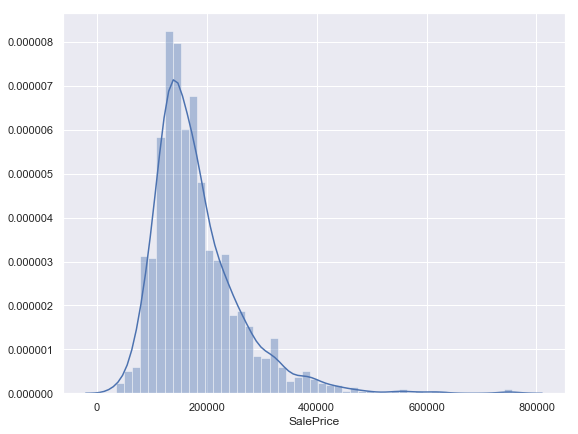

In [90]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train_df['SalePrice']);

In [91]:
#skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


<Figure size 648x504 with 0 Axes>

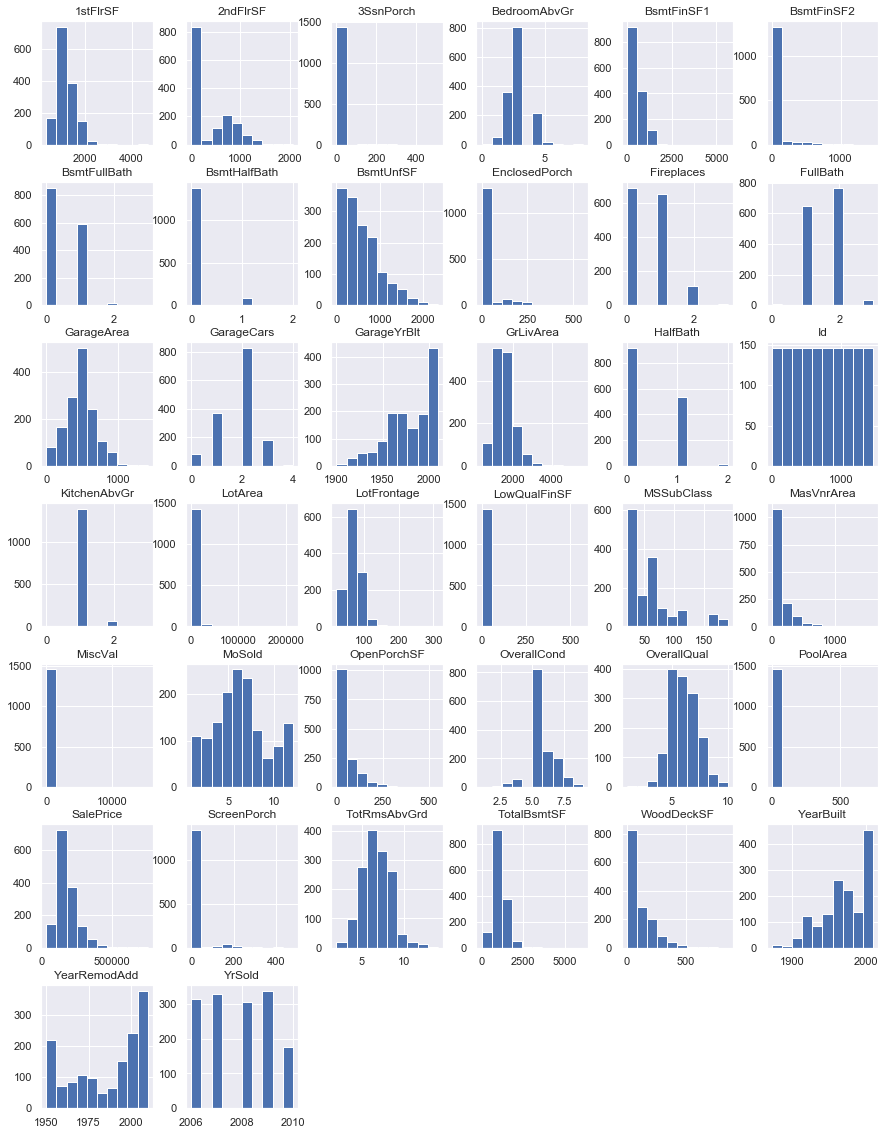

<Figure size 648x504 with 0 Axes>

In [92]:
# histograms
train_df.hist(figsize=(15,20))
plt.figure()

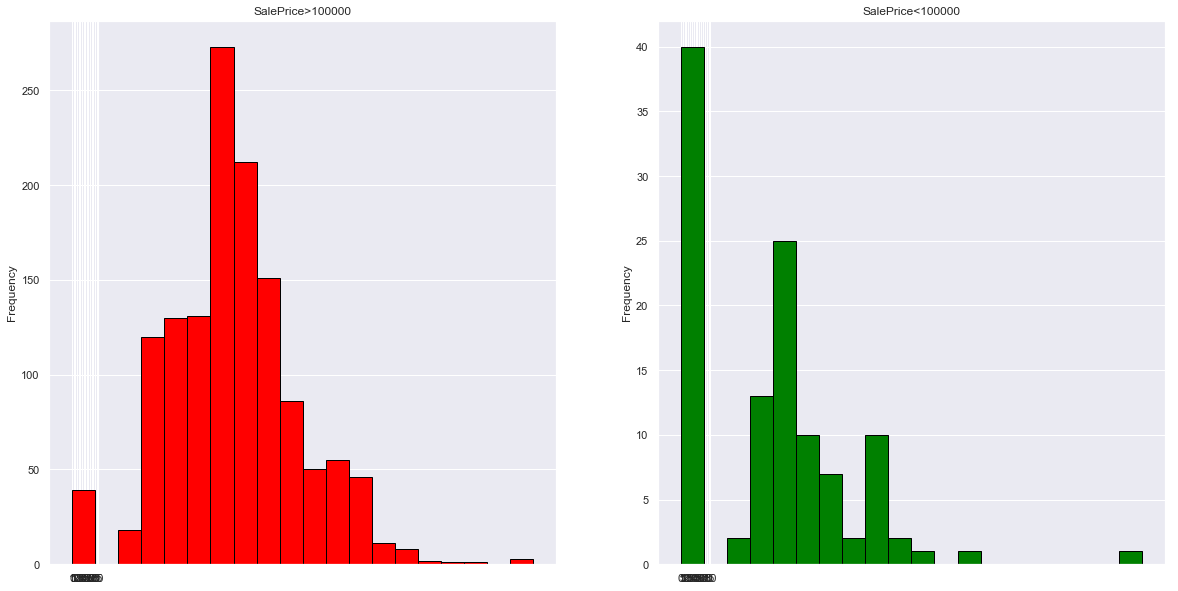

In [93]:
columns = train_df.columns
mini_train=train_df[columns]
f,ax=plt.subplots(1,2,figsize=(20,10))

mini_train[mini_train['SalePrice']>100000].GarageArea.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('SalePrice>100000')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

mini_train[mini_train['SalePrice']<100000].GarageArea.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('SalePrice<100000')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()


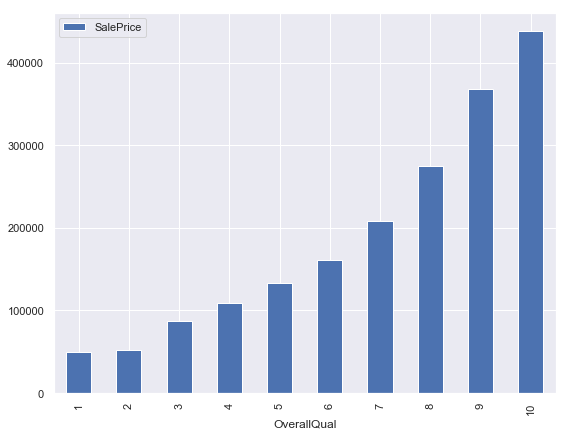

In [94]:
mini_train[['SalePrice','OverallQual']].groupby(['OverallQual']).mean().plot.bar()

<Figure size 648x504 with 0 Axes>

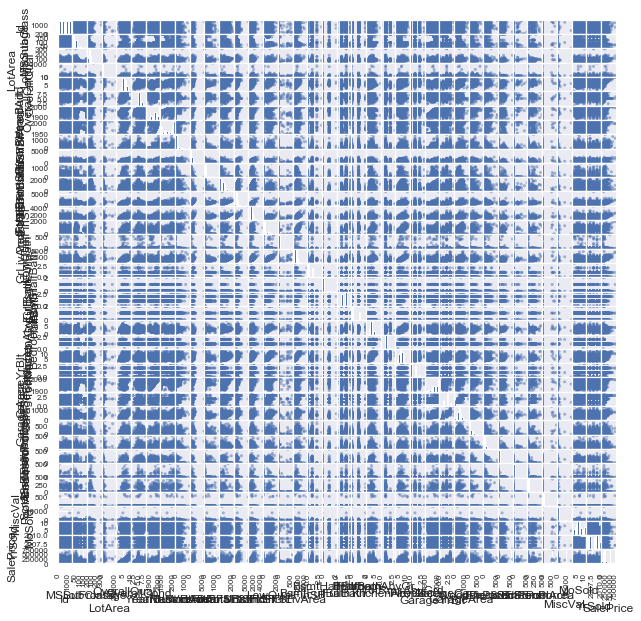

<Figure size 648x504 with 0 Axes>

In [95]:
# scatter plot matrix
pd.plotting.scatter_matrix(train_df[columns],figsize=(10,10))
plt.figure()

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


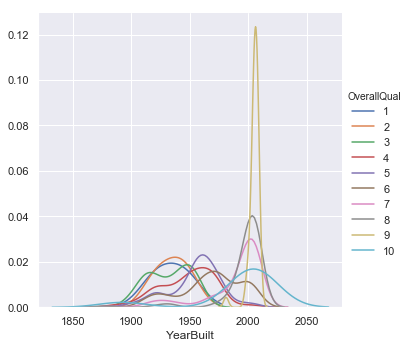

In [96]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.FacetGrid(train_df[columns], hue="OverallQual", size=5).map(sns.kdeplot, "YearBuilt").add_legend()
plt.show()

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


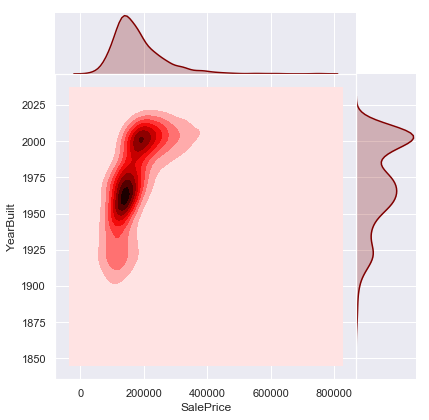

In [97]:
# we will use seaborn jointplot shows bivariate scatterplots and univariate histograms with Kernel density 
# estimation in the same figure
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.jointplot(x="SalePrice", y="YearBuilt", data=train_df[columns], size=6, kind='kde', color='#800000', space=0)

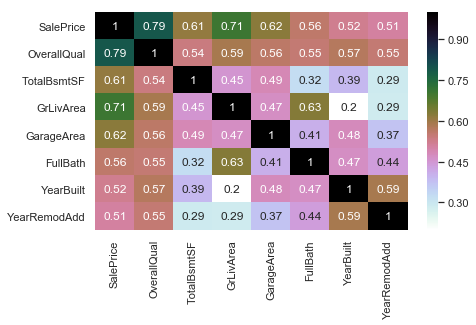

In [98]:
plt.figure(figsize=(7,4)) 
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
sns.heatmap(train_df[columns].corr(),annot=True,cmap='cubehelix_r') #draws  heatmap with input as the correlation matrix calculted by(iris.corr())
plt.show()

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.radviz' is deprecated, import 'pandas.plotting.radviz' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


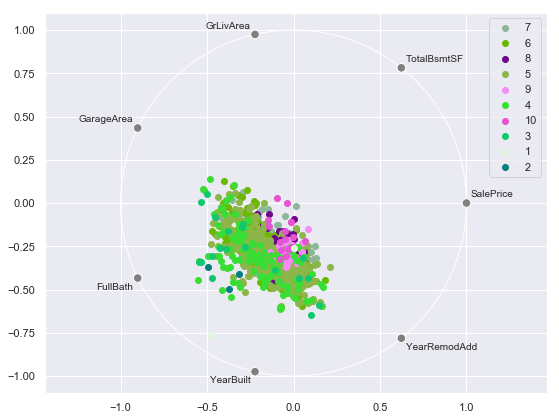

In [99]:
from pandas.tools.plotting import radviz
columns = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageArea','FullBath','YearBuilt','YearRemodAdd']
radviz(train_df[columns], "OverallQual")

### Data Processing

In [100]:
#removing Target column (id)
#Sampling (without replacement)
#Making part of iris unbalanced and balancing (with undersampling and SMOTE)
#Introducing missing values and treating them (replacing by average values)
#Noise filtering
#Data discretization
#Normalization and standardization
#PCA analysis
#Feature selection (filter, embedded, wrapper)

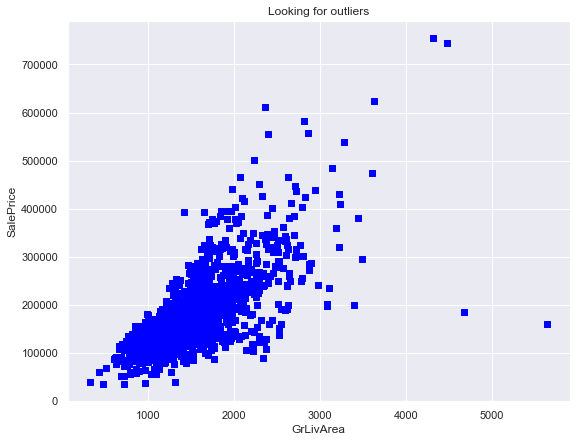

In [101]:
# Looking for outliers
plt.scatter(train_df.GrLivArea, train_df.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train_df[train_df.GrLivArea < 4000]

In [102]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

In [103]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [104]:
all_data = pd.get_dummies(all_data)

In [105]:
# Log transform the target for official scoring
#The key point is to to log_transform the numeric variables since most of them are skewed.
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

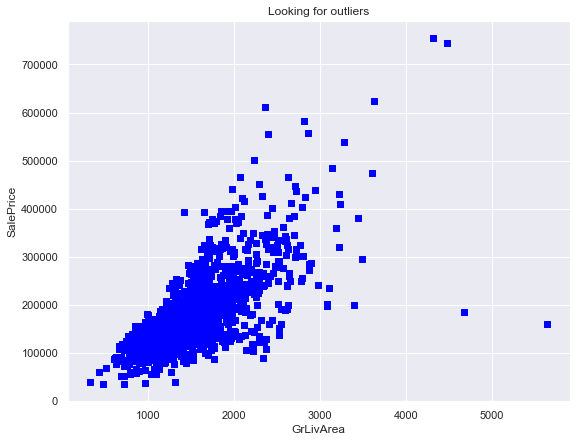

In [106]:
plt.scatter(train_df.GrLivArea, train_df.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

### Data Cleaning

In [107]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

### Modeling

In [108]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [110]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0, 0.5, 'rmse')

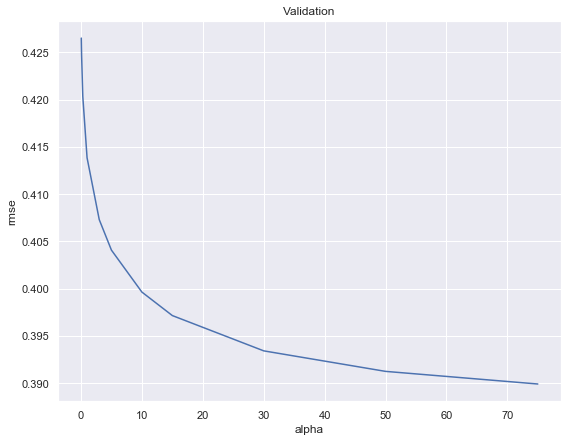

In [111]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [112]:
# steps
steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

# Create the GridSearchCV object: cv
cv = GridSearchCV(pipeline, parameters, cv=3)

# Fit to the training set
cv.fit(X_train, y)

#predict on train set
y_pred_train=cv.predict(X_train)

# Predict test set
y_pred_test=cv.predict(X_test)

# rmse on train set
rmse = np.sqrt(mean_squared_error(y, y_pred_train))
print("Root Mean Squared Error: {}".format(rmse))

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stan

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stan

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stan

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stand

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stand

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stand

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stand

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stan

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by Stan

Root Mean Squared Error: 0.3278663344175412


C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [114]:
# shape to export
output=pd.concat([y_id, pd.DataFrame(np.exp(y_pred_test)-1)], axis=1, ignore_index=True)
output.columns=['Id', 'SalePrice']

# export
output.to_csv('./output/submission.csv', sep=',', index=False)